In [5]:
# Standard definitions needed for script
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import math
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from numpy.polynomial.polynomial import polyfit

In [6]:
# set-up for query to GAIA archive
from astroquery.gaia import Gaia
tables = Gaia.load_tables(only_names=True)
for table in (tables):
     print (table.get_qualified_name())

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Retrieving tables...
Parsing tables...
Done.
external.external.gaiadr2_geometric_distance
public.public.dual
public.public.hipparcos
public.public.hipparcos_newreduction
public.public.hubble_sc
public.public.igsl_source
public.public.igsl_source_catalog_ids
public.public.tycho2
tap_schema.tap_schema.columns
tap_schema.tap_schema.key_columns
tap_schema.tap_schema.keys
tap_schema.tap_schema.schemas
tap_schema.tap_schema.tables
gaiadr1.gaiadr1.aux_qso_icrf2_match
gaiadr1.gaiadr1.ext_phot_zero_point
gaiadr1.gaiadr1.allwise_best_neighbour
gaiadr1.gaiadr1.allwise_neighbourhood
gaiadr1.gaiadr1.gsc23_best_neighbour
gaiadr1.gaiadr1.gsc23_neighbourhood
gaiadr1.gaiadr1.ppmxl_best_neighbour
gaiadr1.gaiadr1.ppmxl_neighbourhood
gaiadr1.gaiadr1.sdss_dr9_best_neighbour
gaiadr1.gaiadr1.sdss_dr9_neighbourhood
gaiadr1.gaiadr1.tmass_best_neighbour
gaiadr1.gaiadr1.tmass_neighbourhood
gaiadr1.gaiadr1.ucac4

In [7]:
# AND g.source_id = wbest.source_id AND wbest.allwise_oid = wise.allwise_oid \
# gaiadr2.allwise_best_neighbour AS wbest, gaiadr1.allwise_original_valid AS wise\

In [8]:
# send request to GAIA archive
# the items in the box command are (corrdinate system, RA in deg, Dec in 
#deg, box width in RA and Dec in deg)
query = "SELECT * \
FROM gaiadr2.gaia_source AS g, gaiadr2.tmass_best_neighbour AS tbest, gaiadr1.tmass_original_valid AS tmass, \
gaiadr2.allwise_best_neighbour AS wbest \
WHERE g.source_id = tbest.source_id AND tbest.tmass_oid = tmass.tmass_oid \
AND g.source_id = wbest.source_id \
AND CONTAINS(POINT('ICRS',g.ra,g.dec),BOX('ICRS',277.49,-1.00,5.,5.))=1 AND (parallax >=1.7 AND parallax_over_error >=3);"

In [9]:
job1 = Gaia.launch_job_async(query, dump_to_file=False)
# this retrieves the result from the query above and puts into a table with the name "GTab"
# The next line prints out the labels for all of the columns in the table
GTab = job1.get_results() 
print (GTab.colnames)
Gra = GTab["ra"]
Gdec = GTab["dec"]
Gpmra = GTab["pmra"]
Gpmra_e = GTab["pmra_error"]
Gpmdec = GTab["pmdec"]
Gpmdec_e = GTab["pmdec_error"]
Gpar = GTab["parallax"]
Gpar_sn = GTab["parallax_over_error"]
Gsepar = GTab["angular_distance"]
G2MASS = GTab["designation_2"]
print(" GAIA Table contains ",len(Gra)," sources")

Query finished.
['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_

In [10]:
#creates list of indentifiers from 2MASS? 

gaia_list = []
for i in range(0,len(G2MASS)):
    gaia_list.append(G2MASS[i].decode('utf-8'))

In [11]:
#read in gould belt YSO catalog

infile = "SERAQU-YSOs.tbl"
GBYSO = Table.read(infile,format="ascii.ipac")
# print(GBYSO.colnames)
GBYSOra = GBYSO["ra"]
GBYSOdec = GBYSO["dec"]
GBYSO2MASS = GBYSO["id2mass"]
print("Read ",len(GBYSOra)," YSOs from GB YSO catalog")

#match up GAIA catalog and Gould Belt YSO
GBYSO_match = np.empty(len(GBYSO2MASS),dtype=int); GBYSO_match.fill(-2)
for j in range(0,len(GBYSO2MASS)):
    if(GBYSO2MASS[j] in gaia_list):
        GBYSO_match[j] = gaia_list.index(GBYSO2MASS[j])
    else:
        GBYSO_match[j] = -2
good_GBYSO = GBYSO_match > -1
print(len(GBYSO_match[good_GBYSO]))
print(np.where(GBYSO_match > -1))

Read  1442  YSOs from GB YSO catalog
47
(array([ 150,  160,  194,  253,  279,  309,  347,  348,  380,  382,  428,
        433,  495,  520,  690,  730,  734,  833,  939,  961,  979,  992,
       1036, 1042, 1047, 1067, 1068, 1093, 1095, 1132, 1133, 1138, 1145,
       1155, 1185, 1213, 1226, 1227, 1233, 1253, 1258, 1276, 1312, 1330,
       1341, 1356, 1388]),)


In [12]:
#read in gould belt stars + dust catalgog

infile = "SERP_GB_star+dust.tbl"
GBSD = Table.read(infile,format="ascii.ipac")
# print(GBSD.colnames)
GBSDra = GBSD["ra"]
GBSDdec = GBSD["dec"]
GBSD2MASS = GBSD["id2mass"]
print("Read ",len(GBSDra)," YSOs from GB Star+Dust catalog")

#match up GAIA catalog and Gould Belt stars+dust
GBSD_match = np.empty(len(GBSD2MASS),dtype=int); GBSD_match.fill(-2)
for j in range(0,len(GBSD2MASS)):
    if(GBSD2MASS[j] in gaia_list):
        GBSD_match[j] = gaia_list.index(GBSD2MASS[j])
    else:
        GBSD_match[j] = -2
good_GBSD = GBSD_match > -1
print(len(GBSD_match[good_GBSD]))
print(np.where(GBSD_match > -1))

Read  3725  YSOs from GB Star+Dust catalog
22
(array([ 744,  850, 1336, 2107, 2194, 2751, 2752, 3084, 3119, 3136, 3175,
       3267, 3287, 3310, 3326, 3344, 3346, 3489, 3501, 3512, 3530, 3549]),)


In [13]:
#read in c2d YSO catalog 

infile = "catalog-SER-YSOc.tbl"
c2dYSO = Table.read(infile,format="ascii.ipac")
#print(c2dYSO.colnames)
c2dYSOra = c2dYSO["ra"]
c2dYSOdec = c2dYSO["dec"]
c2dYSO2MASS = c2dYSO["id2mass"]
c2dYSOobj = c2dYSO["object_type"]
print("Read ",len(c2dYSOra)," YSOs from c2d YSO catalog")

#match up GAIA catalog and c2d YSO catalog
c2dYSO_match = np.empty(len(c2dYSO2MASS),dtype=int); c2dYSO_match.fill(-2)
for j in range(0,len(c2dYSO2MASS)):
    if(c2dYSO2MASS[j] in gaia_list):
        c2dYSO_match[j] = gaia_list.index(c2dYSO2MASS[j])
    else:
        c2dYSO_match[j] = -2
good_c2dYSO = c2dYSO_match > -1
print(len(c2dYSO_match[good_c2dYSO]))
print(np.where(c2dYSO_match > -1))

Read  262  YSOs from c2d YSO catalog
53
(array([  0,   6,  11,  15,  16,  33,  36,  43,  56,  57,  70,  72,  78,
        79,  81, 101, 113, 120, 125, 127, 132, 134, 136, 137, 138, 139,
       141, 142, 144, 145, 159, 175, 179, 184, 186, 189, 197, 207, 208,
       212, 218, 232, 233, 235, 238, 239, 242, 245, 246, 250, 251, 255, 259]),)


In [14]:
#read in c2d YSO stars+dust catalog

infile = "SERP_c2d_star+dust.tbl"
c2dSD = Table.read(infile,format="ascii.ipac")
# print(GBSD.colnames)
c2dSDra = c2dSD["ra"]
c2dSDdec = c2dSD["dec"]
c2dSD2MASS = c2dSD["id2mass"]
print("Read ",len(c2dSDra)," YSOs from c2d Star+Dust catalog")

#match up GAIA catalog and c2d YSO catalog
c2dSD_match = np.empty(len(c2dSD2MASS),dtype=int); c2dSD_match.fill(-2)
for j in range(0,len(c2dSD2MASS)):
    if(c2dSD2MASS[j] in gaia_list):
        c2dSD_match[j] = gaia_list.index(c2dSD2MASS[j])
    else:
        c2dSD_match[j] = -2
good_c2dSD = c2dSD_match > -1
print(len(c2dSD_match[good_c2dSD]))
print(np.where(c2dSD_match > -1))

Read  256  YSOs from c2d Star+Dust catalog
16
(array([  2,  51,  54, 126, 128, 142, 153, 201, 217, 219, 223, 224, 228,
       235, 238, 251]),)


In [15]:
#total number of YSO matches

YSO_match = c2dYSO_match; YSO_match = np.append(YSO_match,GBYSO_match)
good_YSO = YSO_match > -1
print("Total number of GAIA matches to YSOs: ",len(YSO_match[good_YSO]))
SD_match = c2dSD_match; SD_match = np.append(SD_match,GBSD_match)
good_SD = SD_match > -1
print("Total number of GAIA matches to star+dust: ",len(SD_match[good_SD]))

Total number of GAIA matches to YSOs:  100
Total number of GAIA matches to star+dust:  38


Number of YSO matches in the correct distance interval:  80
Number of YSO with parallax > 5, 10, 20:  76 52 26


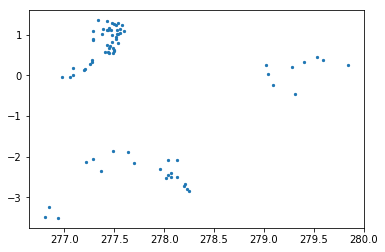

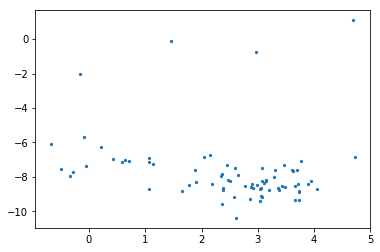

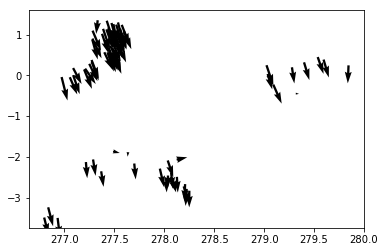

Mean proper motion (Ra,Dec):  2.72522406379 -7.63598293331
Median proper motion (Ra,Dec):  3.03968761909 -8.34163909798


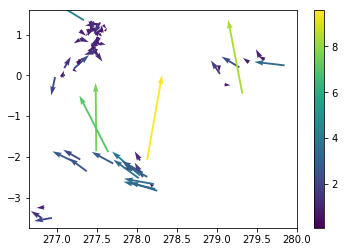

In [16]:
#properties of good YSO matches
raYSO = np.zeros(len(YSO_match[good_YSO]))
decYSO = np.zeros(len(YSO_match[good_YSO]))
pmraYSO = np.zeros(len(YSO_match[good_YSO]))
pmdecYSO = np.zeros(len(YSO_match[good_YSO]))
pmra_eYSO = np.zeros(len(YSO_match[good_YSO]))
pmdec_eYSO = np.zeros(len(YSO_match[good_YSO]))
parYSO = np.zeros(len(YSO_match[good_YSO]))
par_snYSO = np.zeros(len(YSO_match[good_YSO]))
nyso = 0

#find number of YSO matches in the correct interval
for i in range(0,len(YSO_match)):
    if(YSO_match[i] > -1):
        j = YSO_match[i]
        if(1000./Gpar[j] > 350. and 1000/Gpar[j] < 550.):
            raYSO[nyso] = Gra[j]
            decYSO[nyso] = Gdec[j]
            pmraYSO[nyso] = Gpmra[j]
            pmdecYSO[nyso] = Gpmdec[j]
            parYSO[nyso] = Gpar[j]
            par_snYSO[nyso] = Gpar_sn[j]
            nyso = nyso + 1        
print("Number of YSO matches in the correct distance interval: ",nyso)

#find number of YSOs within parallax S/N greater than certain amount
parsn10 = par_snYSO > 10.
parsn5 = par_snYSO > 5
parsn20 = par_snYSO > 20
print("Number of YSO with parallax > 5, 10, 20: ", len(par_snYSO[parsn5]),len(par_snYSO[parsn10]),len(par_snYSO[parsn20]))

#scatter plot of ra and dec
plt.scatter(raYSO[parsn5],decYSO[parsn5],s=5)
plt.show()
#scatter plot of proper motions
plt.scatter(pmraYSO[parsn5],pmdecYSO[parsn5],s=5)
plt.show()
#plot of YSOs at ra and dec with proper motions
plt.quiver(raYSO[parsn5],decYSO[parsn5],pmraYSO[parsn5],pmdecYSO[parsn5])
plt.show()
#mean proper motions
mean_pmra = np.mean(pmraYSO[parsn10])
mean_pmdec = np.mean(pmdecYSO[parsn10])
print("Mean proper motion (Ra,Dec): ",mean_pmra,mean_pmdec)
#median proper motions
median_pmra = np.median(pmraYSO[parsn10])
median_pmdec = np.median(pmdecYSO[parsn10])
print("Median proper motion (Ra,Dec): ",median_pmra,median_pmdec)
#deviation from median of proper motion  of S/N > 10 ysos
rpmraYSO = pmraYSO - median_pmra
rpmdecYSO = pmdecYSO - median_pmdec
#magnitude of deviation from median of proper motion
pmmagYSO = np.zeros(len(YSO_match[good_YSO]))
pmmagYSO = np.power((rpmraYSO*rpmraYSO+rpmdecYSO*rpmdecYSO),0.5)
#plot of YSOs at ra and dec with deviation from median of proper motion
plt.quiver(raYSO[parsn5],decYSO[parsn5],rpmraYSO[parsn5],rpmdecYSO[parsn5],pmmagYSO[parsn5])
plt.colorbar()
plt.show()

In [17]:
#determine high proper motion YSOs 
high_pmYSO = pmmagYSO[parsn5] > 8.
for i in range(0,len(high_pmYSO)):
    if(high_pmYSO[i]):
        j = YSO_match[i] #identifier of YSO match
        print(Gra[j],Gdec[j],c2dYSOobj[i],rpmraYSO[i],rpmdecYSO[i],pmmagYSO[i])

277.467589037 0.107927928724 YSOc_star+dust(IR1) -0.585614106425 1.01117830244 1.1685142023
277.467589037 0.107927928724 YSOc 0.0123510185112 -0.752984388651 0.753085677204


In [18]:
#FIXED determine high proper motion YSOs
for i in range(0,len(pmmagYSO)):
    if(pmmagYSO[i] > 8): 
        j = YSO_match[i] #identifier of YSO match
        print(Gra[j],Gdec[j],c2dYSOobj[i],rpmraYSO[i],rpmdecYSO[i],pmmagYSO[i],par_snYSO[i])
        #figure out difference between i and j

277.467589037 0.107927928724 YSOc_red 1.65691268652 9.43458991931 9.57897941309 30.1823787689
277.467589037 0.107927928724 YSOc_red -1.58031689348 8.22787903596 8.37826920755 40.8754005432
277.467589037 0.107927928724 YSOc_star+dust(MP1) -3.03968761909 8.34163909798 8.87821173788 0.0
277.284136648 1.0956421736 YSOc_star+dust(MP1) -3.03968761909 8.34163909798 8.87821173788 0.0
277.467589037 0.107927928724 YSOc -3.03968761909 8.34163909798 8.87821173788 0.0
277.467589037 0.107927928724 YSOc_star+dust(IR4) -3.03968761909 8.34163909798 8.87821173788 0.0
277.467589037 0.107927928724 YSOc_star+dust(MP1) -3.03968761909 8.34163909798 8.87821173788 0.0
277.467589037 0.107927928724 YSOc_star+dust(MP1) -3.03968761909 8.34163909798 8.87821173788 0.0
277.467589037 0.107927928724 YSOc_star+dust(IR4) -3.03968761909 8.34163909798 8.87821173788 0.0
277.467589037 0.107927928724 YSOc_star+dust(IR3) -3.03968761909 8.34163909798 8.87821173788 0.0
277.467589037 0.107927928724 YSOc_star+dust(MP1) -3.03968761

In [19]:
print(len(YSO_match))
print(len(high_pmYSO))

1704
76


Number of Star+dusts sources in distance interval:  28
Number of SD with parallax > 5, 10, 20:  23 14 8


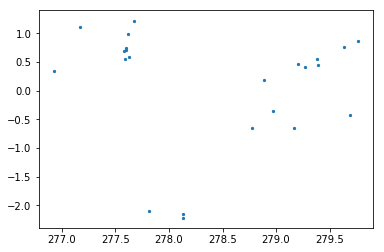

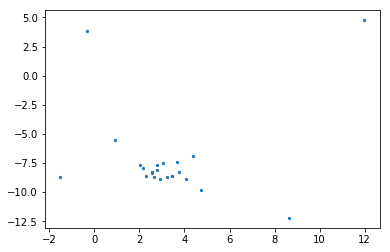

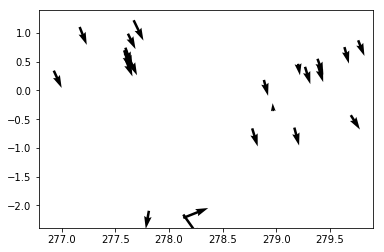

Mean proper motion (Ra,Dec):  3.31667142763 -6.40853803665
Median proper motion (Ra,Dec):  3.03968761909 -8.34163909798


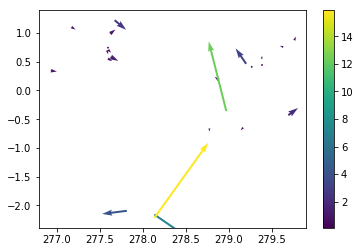

In [20]:
#properties of good star + dust matches
raSD = np.zeros(len(SD_match[good_SD]))
decSD = np.zeros(len(SD_match[good_SD]))
pmraSD = np.zeros(len(SD_match[good_SD]))
pmdecSD = np.zeros(len(SD_match[good_SD]))
pmra_eSD = np.zeros(len(SD_match[good_SD]))
pmdec_eSD = np.zeros(len(SD_match[good_SD]))
parSD = np.zeros(len(SD_match[good_SD]))
par_snSD = np.zeros(len(SD_match[good_SD]))
pmmagSD = np.zeros(len(SD_match[good_SD]))
nsd = 0

#find number of star+dust matches in the correct interval
for i in range(0,len(SD_match)):
    if(SD_match[i] > -1):
        j = SD_match[i]
        if(1000./Gpar[j] > 350. and 1000./Gpar[j]<550):
            raSD[nsd] = Gra[j]
            decSD[nsd] = Gdec[j]
            pmraSD[nsd] = Gpmra[j]
            pmdecSD[nsd] = Gpmdec[j]
            parSD[nsd] = Gpar[j]
            par_snSD[nsd] = Gpar_sn[j]
            nsd = nsd + 1
print("Number of Star+dusts sources in distance interval: ",nsd)

#find number of star+dust within parallax S/N greater than certain amount
parsn10SD = par_snSD > 10.
parsn5SD = par_snSD > 5
parsn20SD = par_snSD > 20
print("Number of SD with parallax > 5, 10, 20: ", len(par_snSD[parsn5SD]),len(par_snSD[parsn10SD]),len(par_snSD[parsn20SD]))

#scatter plot of ra and dec
plt.scatter(raSD[parsn5SD],decSD[parsn5SD],s=5)
plt.show()
#scatter plot of proper motion in ra and dec
plt.scatter(pmraSD[parsn5SD],pmdecSD[parsn5SD],s=5)
plt.show()
#plot of stars+dust at ra and dec with proper motion vector indciated
plt.quiver(raSD[parsn5SD],decSD[parsn5SD],pmraSD[parsn5SD],pmdecSD[parsn5SD])
plt.show()
#mean proper motion in ra and dec
mean_pmraSD = np.mean(pmraSD[parsn10SD])
mean_pmdecSD = np.mean(pmdecSD[parsn10SD])
print("Mean proper motion (Ra,Dec): ",mean_pmraSD,mean_pmdecSD)
#median proper motion in ra and dec
median_pmraSD = np.median(pmraSD[parsn10SD])
median_pmdecSD = np.median(pmdecSD[parsn10SD])
print("Median proper motion (Ra,Dec): ",median_pmra,median_pmdec)
#
rpmraSD = pmraSD - median_pmraSD
rpmdecSD = pmdecSD - median_pmdecSD
pmmagSD = np.zeros(len(SD_match[good_SD]))
pmmagSD = np.power((rpmraSD*rpmraSD+rpmdecSD*rpmdecSD),0.5)
plt.quiver(raSD[parsn5SD],decSD[parsn5SD],rpmraSD[parsn5SD],rpmdecSD[parsn5SD],pmmagSD[parsn5SD])
plt.colorbar()
plt.show()

9058
Number of sources in distance range: 3180
3180


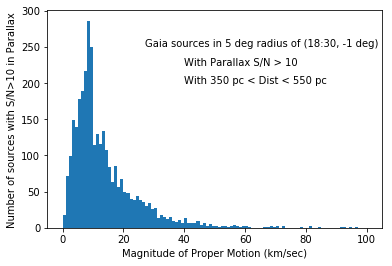

In [21]:
#define variables
ra_big = GTab["ra"]
dec_big = GTab["dec"]
par_big = GTab["parallax"]
pare_big = GTab["parallax_error"]
parsn_big = GTab["parallax_over_error"]
pmra_big = GTab["pmra"]
pmdec_big = GTab["pmdec"]
print(len(ra_big))

#count number of sources in distance range
nn = 0
for i in range(0,len(ra_big)):
     dist = 1000/par_big[i]
     if(dist > 350. and dist <550. and parsn_big[i]>10.):
         nn = nn + 1
print("Number of sources in distance range:", nn)


secperyr = 60*60*24*365.25
to_kms = 443./1000. * 1.496e8/secperyr

#find magnitude of proper motion for sources with S/N greater than 10 in parallax
pm_mag = np.zeros(0)
for i in range(0,len(ra_big)):
     dist = 1000/par_big[i]
     if(dist > 350. and dist <550. and parsn_big[i]>10.):
         pm2 = pmra_big[i]*pmra_big[i] + pmdec_big[i]*pmdec_big[i]
         pm = np.power(pm2,0.5)
         pm_mag = np.append(pm_mag,pm)
print(len(pm_mag))

#create histogram of number of sources for each proper motion magnitude
plt.hist(pm_mag,bins=100,range=(0,100))
plt.xlabel("Magnitude of Proper Motion (km/sec)")
plt.ylabel("Number of sources with S/N>10 in Parallax")
plt.text(27,250,"Gaia sources in 5 deg radius of (18:30, -1 deg)")
plt.text(40,225,"With Parallax S/N > 10")
plt.text(40,200,"With 350 pc < Dist < 550 pc")
plt.savefig("big-Serp-pms.png")
plt.show()

In [ ]:
#calculate proper motion in km/s 

In [23]:
mydec = -1.00
myra = 277.49

from astroquery.irsa import Irsa
Irsa.ROW_LIMIT = 10000 #value of new row limit here
Irsa.list_catalogs()
irsatable = Irsa.query_region(SkyCoord(myra,mydec,unit=(u.deg,u.deg),frame='icrs'),catalog='allwise_p3as_psd',\
                              spatial='Box',width=5*u.deg)
print(irsatable['designation','ra','dec','w3mpro','w3sigmpro','id'])

TableParseError: Failed to parse IRSA votable! The raw response can be found in self.response, and the error in self.table_parse_error.

In [28]:
WISE_YSO = Table.read('WISE_SVM_YSO_class1+2.vot',format='votable')
print(WISE_YSO.colnames)

['Name', 'RAJ2000', 'DEJ2000', 'GLON', 'GLAT', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'extflag', 'phQual', '_2MASSKey', 'Jmag', 'Hmag', 'Ksmag', 'SName', 'SType', 'SDist', 'tau']


In [30]:
#match up GAIA catalog and WISE YSO catalog
WISE_YSO2MASS = WISE_YSO['_2MASSKey']
WISE_YSO_match = np.empty(len(WISE_YSO2MASS),dtype=int)
WISE_YSO_match.fill(-2)
for j in range(0,len(WISE_YSO2MASS)):
    if(WISE_YSO2MASS[j] in gaia_list):
        WISE_YSO_match[j] = gaia_list.index(WISE_YSO2MASS[j])
    else:
        WISE_YSO_match[j] = -2
good_WISE_YSO = WISE_YSO_match > -1
print(len(WISE_YSO_match[good_WISE_YSO]))
print(np.where(WISE_YSO_match > -1))

0
(array([], dtype=int64),)


In [35]:
print(WISE_YSO2MASS)

_2MASSKey 
----------
 375190046
 375080559
 375251188
 375247116
 375363364
 375301139
 375364655
 375415704
 375252934
 414802272
       ...
1183101511
1183101995
1174655124
1183101834
 623608805
1183013305
1183100738
 623425021
 623077220
 623422385
 623426453
Length = 679 rows


In [36]:
print(gaia_list)

['18220043-0302449', '18203839-0249259', '18223330-0235454', '18220447-0249522', '18203688-0301572', '18223439-0233474', '18213729-0238494', '18211718-0309089', '18213256-0255257', '18203029-0304236', '18211223-0306114', '18215408-0240015', '18223068-0252318', '18212676-0305108', '18221362-0235025', '18214826-0252132', '18211163-0312062', '18212422-0309269', '18233959-0250521', '18203539-0302026', '18200329-0302070', '18222876-0253546', '18221061-0242001', '18215540-0303529', '18223300-0246418', '18220610-0239490', '18211568-0314201', '18224193-0248330', '18215815-0249497', '18233010-0251340', '18204450-0310057', '18233554-0252059', '18223690-0250037', '18231844-0251204', '18222520-0253083', '18230908-0237237', '18222049-0301088', '18214353-0301300', '18213766-0247276', '18212047-0245349', '18214822-0238142', '18214559-0301098', '18203521-0304363', '18213125-0242519', '18201371-0305537', '18204115-0310290', '18213135-0240019', '18212171-0239433', '18202122-0257059', '18205475-0311097',

In [37]:
print(G2MASS)

 designation_2  
----------------
18220043-0302449
18203839-0249259
18223330-0235454
18220447-0249522
18203688-0301572
18223439-0233474
18213729-0238494
18211718-0309089
18213256-0255257
18203029-0304236
             ...
18310895+0024500
18285414+0004387
18313320+0023026
18320257+0017077
18310410+0010249
18250381-0029091
18295502+0008257
18254163-0023368
18304229+0005246
18295221+0006289
18313833+0008567
Length = 9058 rows
